# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Table of Contents

## <ins>Part 0. Get to Know the Data

### <ins>0.0 Load datas and Review of datas</ins>
### <ins>0.1 Data Cleaning and Feature Engineering</ins>
- **0.1.0 Modifying Existing Features to contain useful information**
- **0.1.1 Addressing Unkown Values**
- **0.1.2 Check and Handle Missing Values**
- **0.1.3 Look at Column Types**
- **0.1.4 Imputing Missing Values**
- **0.1.5 Feature Scaling**

## <ins> Part 1. Customer Segmentation Report</ins>
- **1.1 Dimensionality Reduction**
- **1.2 Interpreting PCA Components**
- **1.3 Combine PCA and K-means Clustering**

## <ins> Part 2. Supervised Learning Model</ins>
- **2.1. Selecting the Evaluation Metric**
- **2.2. Cleaning data for Modelling**
- **2.3. Setting The Benchmark**
- **2.4. Trying out Different Models**
- **2.5 Grid Search**
- **2.6 Select Final Model**
- **2.7 Extras (Look at Final Model Optimal Thresholds and Confusion Matrix)**

## <ins> Part 3: Kaggle Competition</ins>

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.0 Load and Review of datas

In [1]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb


from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


# magic word for producing visualizations in notebook
%matplotlib inline

C:\Users\Mustafa\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Load Attribute Info 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

attribute = pd.read_excel('./Data/DIAS Attributes - Values 2017.xlsx',
                          sheet_name='Tabelle1', skiprows=1 )

attribute = attribute.drop('Unnamed: 0', axis=1)
attribute['Attribute'] = attribute['Attribute'].fillna(method='ffill')
attribute['Description'] = attribute['Description'].fillna(method='ffill')
attribute['Meaning'] = attribute['Meaning'].fillna(method='ffill')
attribute['value_mean'] = '(' + attribute['Value'].astype(str) + '):' + attribute['Meaning']


info1 = attribute.groupby(['Attribute']).value_mean.apply(list)
att_info = info1.to_frame().reset_index()


# Load Information levels
info= pd.read_excel('./Data/DIAS Information Levels - Attributes 2017.xlsx',
                     sheet_name = 'Komplett', skiprows=1)

info = info.drop('Unnamed: 0', axis=1)
info['Information level'] = info['Information level'].fillna(method='ffill')

# Information and description of all featrues

att_info = pd.merge(att_info , info , how='outer', on='Attribute')
att_info.head()
# att_info[att_info['Attribute']=='ALTERSKATEGORIE_GROB']


C:\Users\Mustafa\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,Attribute,value_mean,Information level,Description,Additional notes
0,AGER_TYP,"[(-1):unknown, (0):no classification possible, (1):passive elderly, (2):cultural elderly, (3):experience-driven elderly]",NaN,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,ALTERSKATEGORIE_GROB,"[(-1, 0):unknown, (1):< 30 years, (2):30 - 45 years, (3):46 - 60 years, (4):> 60 years, (9):uniformly distributed]",Person,age through prename analysis,modelled on millions of first name-age-reference data
2,ALTER_HH,"[(0):unknown / no main age detectable, (1):01.01.1895 bis 31.12.1899, (2):01.01.1900 bis 31.12.1904, (3):01.01.1905 bis 31.12.1909, (4):01.01.1910 bis 31.12.1914, (5):01.01.1915 bis 31.12.1919, (6):01.01.1920 bis 31.12.1924, (7):01.01.1925 bis 31.12.1929, (8):01.01.1930 bis 31.12.1934, (9):01.01.1935 bis 31.12.1939, (10):01.01.1940 bis 31.12.1944, (11):01.01.1945 bis 31.12.1949, (12):01.01.1950 bis 31.12.1954, (13):01.01.1955 bis 31.12.1959, (14):01.01.1960 bis 31.12.1964, (15):01.01.1965 bis 31.12.1969, (16):01.01.1970 bis 31.12.1974, (17):01.01.1975 bis 31.12.1979, (18):01.01.1980 bis 31.12.1984, (19):01.01.1985 bis 31.12.1989, (20):01.01.1990 bis 31.12.1994, (21):01.01.1995 bis 31.12.1999]",Household,main age within the household,NaN
3,ANREDE_KZ,"[(-1, 0):unknown, (1):male, (2):female]",Person,gender,NaN
4,ANZ_HAUSHALTE_AKTIV,[(…):numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN


In [4]:
# Load Datas

customers = pd.read_csv('./Data/customers.csv',sep=';')
azdias = pd.read_csv('./Data/azdias.csv',sep=';')

C:\Users\Mustafa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Warning:** The warning says, Column 18 and 19 have mixed data types. We explore these columns later.

In [5]:
print('azdias shape: {} '.format(azdias.shape))
print('customers shape: {} '.format(customers.shape))

extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

azdias shape: (891221, 366) 
customers shape: (191652, 369) 
Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [8]:
customers[extra_cols_in_customers].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


**Warning Cols**

We can look at the datatypes of columns 18 and 19 since we got a warning while we loaded the data.

In [9]:
warning_cols = list(azdias.columns[18:20])
print(warning_cols)

['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


In [10]:
# We can see what these 2 columns represent from the attributes dataframe
att_info[att_info['Attribute']=='CAMEO_DEUG_2015']

,Attribute,value_mean,Information level,Description,Additional notes
10,CAMEO_DEUG_2015,"[(-1):unknown, (1):upper class, (2):upper middleclass, (3):established middleclasse, (4):consumption-oriented middleclass , (5):active middleclass , (6):low-consumption middleclass, (7):lower middleclass, (8):working class, (9):urban working class]",Microcell (RR4_ID),CAMEO_4.0: uppergroup,New German CAMEO Typology established together with Call Credit in late 2015


In [11]:
# "CAMEO_INTL_2015" ---> named as "CAMEO_DEUINTL_2015" in attribute values excel sheet
att_info[att_info['Attribute']=='CAMEO_DEUINTL_2015']

,Attribute,value_mean,Information level,Description,Additional notes
11,CAMEO_DEUINTL_2015,"[(-1):unknown, (11):Wealthy Households-Pre-Family Couples & Singles, (12):Wealthy Households-Young Couples With Children, (13):Wealthy Households-Families With School Age Children, (14):Wealthy Households-Older Families & Mature Couples, (15):Wealthy Households-Elders In Retirement, (21):Prosperous Households-Pre-Family Couples & Singles, (22):Prosperous Households-Young Couples With Children, (23):Prosperous Households-Families With School Age Children, (24):Prosperous Households-Older Families & Mature Couples, (25):Prosperous Households-Elders In Retirement, (31):Comfortable Households-Pre-Family Couples & Singles, (32):Comfortable Households-Young Couples With Children, (33):Comfortable Households-Families With School Age Children, (34):Comfortable Households-Older Families & Mature Couples, (35):Comfortable Households-Elders In Retirement, (41):Less Affluent Households-Pre-Family Couples & Singles, (42):Less Affluent Households-Young Couples With Children, (43):Less Affluent Households-Families With School Age Children, (44):Less Affluent Households-Older Families & Mature Couples, (45):Less Affluent Households-Elders In Retirement, (51):Poorer Households-Pre-Family Couples & Singles, (52):Poorer Households-Young Couples With Children, (53):Poorer Households-Families With School Age Children, (54):Poorer Households-Older Families & Mature Couples, (55):Poorer Households-Elders In Retirement]",Microcell (RR4_ID),CAMEO_4.0: international classification,NaN


In [12]:
# Chechk the info and unique values in these columns.

azdias[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  792242 non-null  object
 1   CAMEO_INTL_2015  792242 non-null  object
dtypes: object(2)
memory usage: 13.6+ MB


In [13]:
customers[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  141224 non-null  object
 1   CAMEO_INTL_2015  141224 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


In [14]:
azdias[warning_cols[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [15]:
azdias[warning_cols[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [16]:
customers[warning_cols[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [17]:
customers[warning_cols[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

We have 'X' and 'XX' as values in these columns which have not been given in the description, also there are 'nan' values.

These values can be replaced with 'np.nan', as in the attributes dataframe it is described that any unknown values can be treated as '-1' but for simpicity we can consider this '-1' as 'np.nan'. Also there is inconsistency in the values i.e. some of them are strings and some of them are floats. We can to convert all of them into integers.

In [18]:
def fix_warning_cols(df):
    '''
    Function to replace 'X', 'XX' with 'nan' in 
    columns 18 and 19 i.e. ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] 
    
    df = Related dataframe
    '''
    cols = ["CAMEO_DEUG_2015","CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

In [19]:
customers = fix_warning_cols(customers)
azdias = fix_warning_cols(azdias)

In [20]:
azdias[warning_cols[0]].unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [21]:
azdias[warning_cols[1]].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [22]:
customers[warning_cols[0]].unique()

array([ 1., nan,  5.,  4.,  7.,  3.,  9.,  2.,  6.,  8.])

In [23]:
customers[warning_cols[1]].unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

In [24]:
azdias[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CAMEO_DEUG_2015  791869 non-null  float64
 1   CAMEO_INTL_2015  791869 non-null  float64
dtypes: float64(2)
memory usage: 13.6 MB


In [25]:
customers[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CAMEO_DEUG_2015  141098 non-null  float64
 1   CAMEO_INTL_2015  141098 non-null  float64
dtypes: float64(2)
memory usage: 2.9 MB


In [26]:
print('azdias shape: {} '.format(azdias.shape))
print('customers shape: {} '.format(customers.shape))

azdias shape: (891221, 366) 
customers shape: (191652, 369) 


### 0.1 Data Cleaning and Feature Engineering

At this point we can start cleaning the data. We can go through some columns and verify what values they represent and clean them to contain values that are given in the attribute information data.

Also we can start engineering features from this point, since some columns have mixed information and some have too much information packed into one single column. We can address these issues by creating new features or modifying existing features to contain useful information. Also, not all the features will be relevant for futher steps, these are also addressed in this process.


### <ins>0.1.0 Modifying Existing Features to contain useful information</ins>

* Staring with columns `LP_FAMILIE_*`, `LP_FAMILIE_*`, `LP_LEBENSPHASE_*`, since the have some strange values that have not been specified in the attribute description.

In [27]:
print('LP_FAMILIE_FEIN:{}'.format(azdias.LP_FAMILIE_FEIN.unique()))

print('LP_FAMILIE_GROB:{}'.format(azdias.LP_FAMILIE_GROB.unique()))
     
print('LP_STATUS_GROB:{}'.format(azdias.LP_STATUS_GROB.unique()))

print('LP_LEBENSPHASE_GROB:{}'.format(azdias.LP_LEBENSPHASE_GROB.unique()))

print('LP_LEBENSPHASE_FEIN:{}'.format(azdias.LP_LEBENSPHASE_FEIN.unique()))

print('LP_STATUS_FEIN:{}'.format(azdias.LP_STATUS_FEIN.unique()))

LP_FAMILIE_FEIN:[ 2.  5.  1.  0. 10.  7. 11.  3.  8.  4.  6. nan  9.]
LP_FAMILIE_GROB:[ 2.  3.  1.  0.  5.  4. nan]
LP_STATUS_GROB:[ 1.  2.  4.  5.  3. nan]
LP_LEBENSPHASE_GROB:[ 4.  6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  8. nan]
LP_LEBENSPHASE_FEIN:[15. 21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. nan 40. 16. 17.]
LP_STATUS_FEIN:[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]


In [28]:
print('LP_FAMILIE_FEIN Value_Mean:{}'.format(att_info[att_info['Attribute']=='LP_FAMILIE_FEIN']['value_mean']))

print('LP_FAMILIE_GROB Value_Mean:{}'.format(att_info[att_info['Attribute']=='LP_FAMILIE_GROB']['value_mean']))

print('LP_STATUS_GROB Value_Mean:{}'.format(att_info[att_info['Attribute']=='LP_STATUS_GROB']['value_mean']))

print('LP_LEBENSPHASE_GROB Value_Mean:{}'.format(att_info[att_info['Attribute']=='LP_LEBENSPHASE_GROB']['value_mean']))

print('LP_LEBENSPHASE_FEIN Value_Mean:{}'.format(att_info[att_info['Attribute']=='LP_LEBENSPHASE_FEIN']['value_mean']))

print('LP_STATUS_FEIN Value_Mean:{}'.format(att_info[att_info['Attribute']=='LP_STATUS_FEIN']['value_mean']))

LP_FAMILIE_FEIN Value_Mean:268    [(1):single , (2):couple, (3):young single parent , (4):single parent with teenager, (5):single parent with child of full age, (6):young family , (7):family with teenager , (8):family with child of full age, (9):shared flat, (10):two-generational household, (11):multi-generational household]
Name: value_mean, dtype: object
LP_FAMILIE_GROB Value_Mean:269    [(1):single , (2):couple, (3):single parent, (4):single parent, (5):single parent, (6):family, (7):family, (8):family, (9):multiperson household, (10):multiperson household, (11):multiperson household]
Name: value_mean, dtype: object
LP_STATUS_GROB Value_Mean:273    [(1):low-income earners, (2):low-income earners, (3):average earners, (4):average earners, (5):average earners, (6):independants, (7):independants, (8):houseowners, (9):houseowners, (10):top earners ]
Name: value_mean, dtype: object
LP_LEBENSPHASE_GROB Value_Mean:271    [(1):single low-income- and average earners of younger age , (2):sing

The columns `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`, `LP_LEBENSPHASE_GROB` contains `0` as an entry which does not correspond to any category as the per the values information given in `DIAS Attributes - Values 2017.xlsx`. For this reason, any value which is `0` in these columns can be converted to nan.

Also, in these columns there is a lot of information that can be compressed, which is done by the following function.

* `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` give a fine categorization of the family type and family status. The same information in a broader spectrum is given by `LP_FAMILIE_GROB` and `LP_STATUS_GROB`. For this reason, for this analysis the columns `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` will be dropped. (Not in the function below but at a later stage when all the unwanted columns are removed at once for simplicity)

* `LP_LEBENSPHASE_GROB` gives overall description of the life stage the person is in with respect to age and wealth and `LP_LEBENSPHASE_FEIN` gives a fine categorization of the persons age and financial status. Which means, these two columns are representing same information twice. Therefore, `LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` are restructed so that one of them contains information about age and the other one contains information about wealth.

In [29]:
def fix_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    LP_cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[LP_cols] = df[LP_cols].replace({0: np.nan})
    df[LP_cols] = df[LP_cols].astype(float)
    
    
    # LP_FAMILIE_FEIN
    
    family_convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    family_convert_2 = {'single':1, 'couple':2, 'singleparent':3, 'family':4, 'multihousehold':5}
    
    df["LP_FAMILIE_FEIN"] = df["LP_FAMILIE_FEIN"].map(family_convert_1)
    df["LP_FAMILIE_FEIN"] = df["LP_FAMILIE_FEIN"].map(family_convert_2)

    
    # LP_FAMILIE_GROB
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(family_convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(family_convert_2)
    
    
    
    # LP_STATUS_FEIN
    
    status_convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                        6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    status_convert_2 = {'lowincome':1, 'avgincome':2, 'independant':3, 'houseowner':4, 'topearner':5}
    
   
    df["LP_STATUS_FEIN"] = df["LP_STATUS_FEIN"].map(status_convert_1)
    df["LP_STATUS_FEIN"] = df["LP_STATUS_FEIN"].map(status_convert_2)       
   
    
    
    # LP_STATUS_GROB    

    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(status_convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(status_convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
                   4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
                   7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
                  10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
                  13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
                  16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
                  19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
                  22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
                  25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
                  28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
                  31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
                  34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
                  37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
                  40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
                    7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
                   12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
                   17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
                   22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
                   27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
                   32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
                   37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3, 'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
    
    
    return df
    

In [30]:
customers = fix_LP_cols(customers)
azdias = fix_LP_cols(azdias)

In [31]:
print('LP_FAMILIE_FEIN:{}'.format(azdias.LP_FAMILIE_FEIN.unique()))

print('LP_FAMILIE_GROB:{}'.format(azdias.LP_FAMILIE_GROB.unique()))
     
print('LP_STATUS_GROB:{}'.format(azdias.LP_STATUS_GROB.unique()))

print('LP_LEBENSPHASE_GROB:{}'.format(azdias.LP_LEBENSPHASE_GROB.unique()))

print('LP_LEBENSPHASE_FEIN:{}'.format(azdias.LP_LEBENSPHASE_FEIN.unique()))

print('LP_STATUS_FEIN:{}'.format(azdias.LP_STATUS_FEIN.unique()))

LP_FAMILIE_FEIN:[ 2.  3.  1. nan  5.  4.]
LP_FAMILIE_GROB:[ 2.  3.  1. nan]
LP_STATUS_GROB:[ 1.  2. nan]
LP_LEBENSPHASE_GROB:[ 1.  2. nan  3.  4.]
LP_LEBENSPHASE_FEIN:[ 3.  2.  1. nan  4.]
LP_STATUS_FEIN:[ 1.  2.  4.  5.  3. nan]


* Column `EINGEFUEGT_AM` seems to tell about the date on which the entry was made. Althoug there is no specific description given about this column, this can be converted into a datetime object to see its distribution.

In [32]:
def fix_eigefugt_col(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [33]:
customers = fix_eigefugt_col(customers)
azdias = fix_eigefugt_col(azdias)

C:\Users\Mustafa\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Mustafa\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


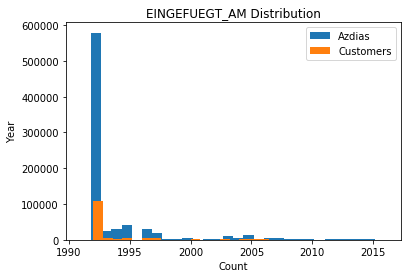

In [34]:
plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias")
plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers")
plt.ylabel("Year")
plt.xlabel("Count")
plt.title("EINGEFUEGT_AM Distribution")
plt.legend()
plt.show()

Seems like the distributions are almost similar. And the people who are registered in years before 1995 are more likely to be customers according to above graph. 

We can further analyse and change other categorical columns after making sure all the unkown values are replaced with NaNs in the dataframes.

###  <ins>0.1.1 Addressing Unkown Values</ins>

There is one more thing we need to do before we start to engineer some features. From the information given in the attributes-values dataframe, some columns have unkown values recorded with specific representations. These unkown representations can be obtained by the following steps. We can later use these representations to change them to *NaN* values, by treating them as missing entries.

In [35]:
unkown_attributes_values = attribute[attribute["Meaning"] == "unknown"]
print(len(unkown_attributes_values))

232


We have **232** columns which have unkown values, these are displayed below. These values in the columns need to be replaced with *NaN* values.

In [36]:
unkown_attributes_values

,Attribute,Description,Value,Meaning,value_mean
0,AGER_TYP,best-ager typology,-1,unknown,(-1):unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"(-1, 0):unknown"
33,ANREDE_KZ,gender,"-1, 0",unknown,"(-1, 0):unknown"
40,BALLRAUM,distance to next urban centre,-1,unknown,(-1):unknown
48,BIP_FLAG,business-flag indicating companies in the building,-1,unknown,(-1):unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown,(-1):unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typology,-1,unknown,(-1):unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown,(0):unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown,(-1):unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown,(-1):unknown


To convert all unknown values into np.nan values we first have to get the value which corresponds to unkown value from the attribute_value data and then replace these values.

In [37]:
# Function of the representation of unkown values
def get_unkown_repr(attrib, unkown_attributes_values):
    """Returns the representation of unkown values
    attrib: Attributes
    unkown_attributes_values: Dataframe of unknown values
    """
    
    unkown = unkown_attributes_values[unkown_attributes_values["Attribute"] == attrib]["Value"]
    unkown = unkown.astype(str).str.cat(sep=",")
    unkown = [int(x) for x in unkown.split(",")]
      
    return [unkown]

In [38]:
# Define funct,on for replaces unkown values with np.nan values if the value mathes with the unkown representation
def replace_unkown_with_nan(val, unkown):
    """Replaces unkown values with np.nan values if the value mathes with the unkown representation"""
    if val in unkown:
        return np.nan
    else:
        return val

In [39]:
# Define function for replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list

def replace_unkowns(df, unkown_attributes_values, verbose=False):
    """
    Replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list.
    
    df: Dataframe 
    unkown_attributes_values: Dataframe of unknown values
    """
    for attrib in unkown_attributes_values.Attribute:
        unkown = get_unkown_repr(attrib, unkown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unkown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
    return df

In [40]:
azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_70
Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Repl

In [41]:
customers = replace_unkowns(customers, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Replacing [[-1]] to NaN in Attribute KBA13_SEG_MINIVA

In [42]:
# This function that gives us a dataframe to preview the missing values and the % of missing values in each column:

def missing_values_table(df):
    
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_percent_df = pd.DataFrame({"Attribute": df.columns,
                                   "Missing_Percentage": mis_val_percent}).reset_index(drop=True)
    
    mis_val_table = mis_val_percent_df
    mis_val_table = mis_val_table[mis_val_table['Missing_Percentage'] != 0].sort_values('Missing_Percentage', ascending=False)
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(mis_val_table.shape[0]) +
           " columns that have missing values.")
    return mis_val_table

In [43]:
customer_missing_report = missing_values_table(customers)
azdias_missing_report = missing_values_table(azdias)

Your selected dataframe has 370 columns.
There are 280 columns that have missing values.
Your selected dataframe has 367 columns.
There are 280 columns that have missing values.


In [44]:
customer_missing_report

,Attribute,Missing_Percentage
7,ALTER_KIND4,99.876860
6,ALTER_KIND3,99.334732
349,TITEL_KZ,98.793647
5,ALTER_KIND2,97.338927
4,ALTER_KIND1,93.860748
300,KK_KUNDENTYP,58.406382
129,KBA05_BAUMAX,57.153069
1,AGER_TYP,48.059504
100,EXTSEL992,44.498883
326,REGIOTYP,31.340137


In [45]:
azdias_missing_report

,Attribute,Missing_Percentage
7,ALTER_KIND4,99.864792
349,TITEL_KZ,99.757636
6,ALTER_KIND3,99.307691
5,ALTER_KIND2,96.690047
4,ALTER_KIND1,90.904837
1,AGER_TYP,76.019640
100,EXTSEL992,73.399639
300,KK_KUNDENTYP,65.596749
129,KBA05_BAUMAX,53.468668
8,ALTERSKATEGORIE_FEIN,29.504130


In [46]:
# Comparing two dataframes features and percentage of missing values based on a threshold percentage given

def plot_percentage_missing ( df1, df2, percentage = 0 , figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    
    df1: Comparing dataframe
    df2: Comparing the other dataframe
    percentage: The threshold of percentage of missing value 
    
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Ratio Dist. of Attributes")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax= ax)
    

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])

    plt.show()

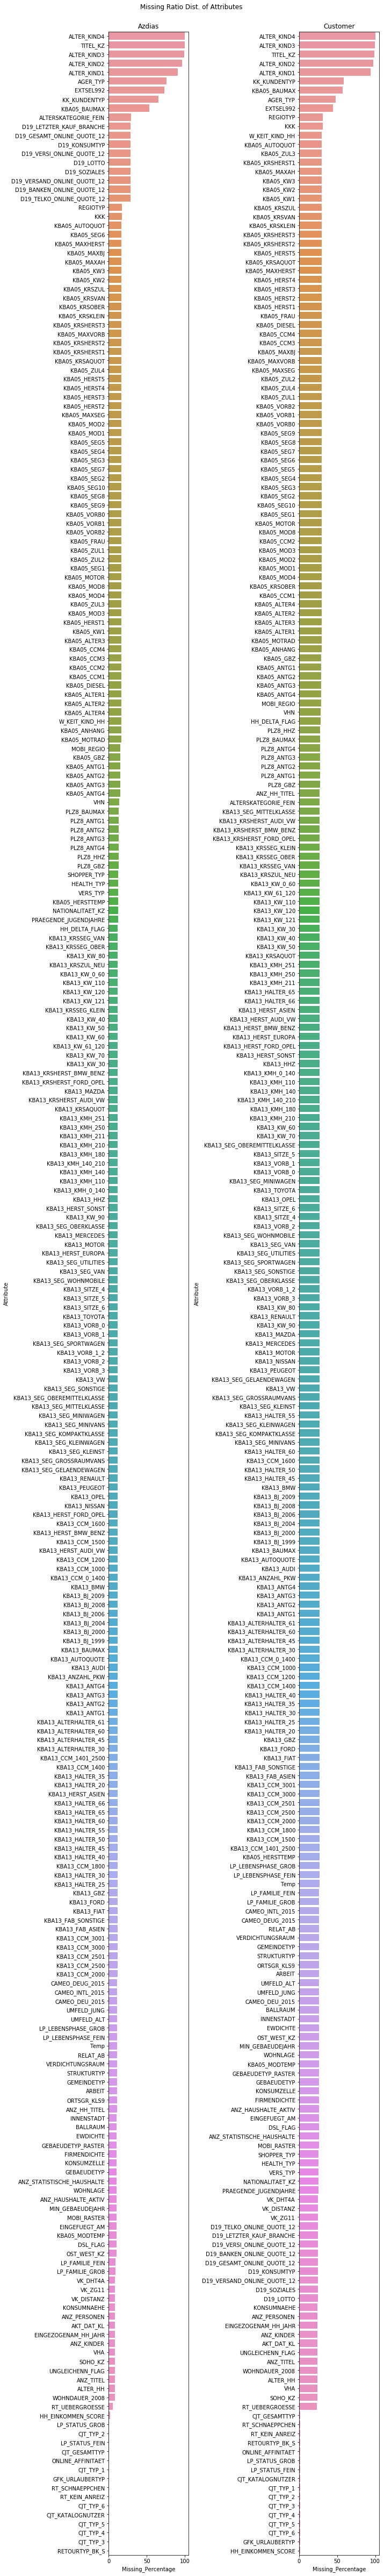

In [47]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=0)

* By looking at the plot above we can conclude what percentage of data is missing from each column where we have missing data. 
* There is overlap in both **Azdias** and **Customers** data i.e. data is missing from same columns.
* Also the percentage of missing values in **Azdias** and **Customers** coincide a lot, which confirms that customers data is a subset of azdias data.

We can threshold the missing percentage and see how many columns have missing data percentage more than the threshold.

We can identified the treshold value as 30%

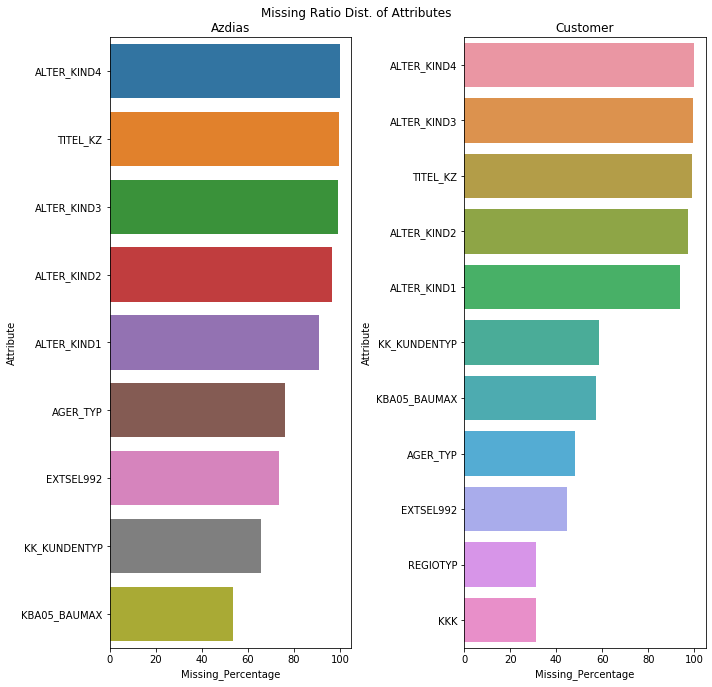

In [48]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=30, figsize=(10, 10))

* We have *11* features with more more than 30% missing values in **Customer** data, where as in **Azdias** data we only have *9* feature. Whereas, in total we had *279* columns with missing values in both dataframes. 
* So *11* and *9* are considerably less nuzmber of features when compared to *279* and we can drop them. 

We are going to remove the features with more than 30% of data from **Customer** data, also the same features have to be removed from **Azdias** data.

In [49]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
         
    df1 = remove_columns(df1, remove_cols)
    df2 = remove_columns(df2, remove_cols)
    print(f"\t\tRemoved {len(remove_cols)} columns from given dataframes")
    
    return (df1, df2, remove_cols)

In [50]:
print("Number of columns Before dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

azdias, customers, removed_cols = remove_missing_columns(azdias, customers, customer_missing_report, azdias_missing_report)

print("Number of columns After dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns Before dropping
Azdias - 367
Customers - 370
		Removed 11 columns from given dataframes
Number of columns After dropping
Azdias - 356
Customers - 359


#### Missing values Row-wise

After removing the columns which have more than 30% missing values, now we can look at the dataframes with remaining features for any missing values in rows.

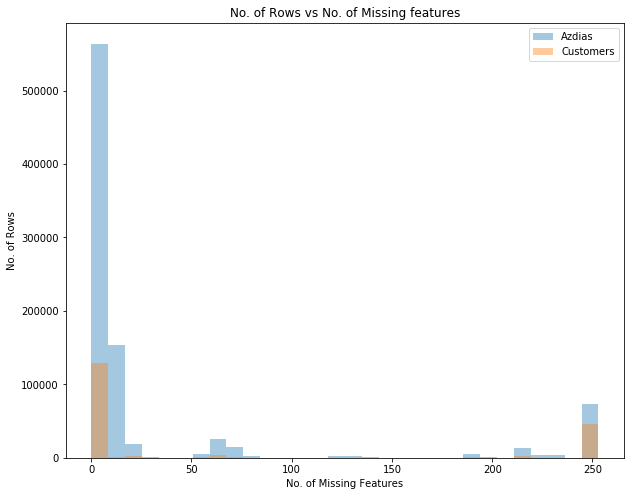

In [51]:
# Takes in two dataframes and plots a barchart comparing two dataframes 
# rows and percentage of missing values based on a threshold percentage given

def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,8)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()
    
    
plot_missing_rowwise_histogram(azdias, customers)

From the above plot we can conclude,
* We have *250/355* features missing in approximately *70000* rows in **Azdias** and approximately *50000* rows in **Customers** data.
* Most of the rows have less than 50 missing values in both dataframes.
* **Customers** data has comparatively more missving rows than **Azdias**.

Now we can drop all the rows which have more than 50 missing values.

In [52]:
# Define function for drop rows based on threshold 

def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [53]:
print("Number of rows Before dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print("Number of rows After dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

Number of rows Before dropping
Azdias - 891221
Customers - 191652
		Removed 57406 rows from  dataframe
		Removed 153933 rows from  dataframe
Number of rows After dropping
Azdias - 737288
Customers - 134246


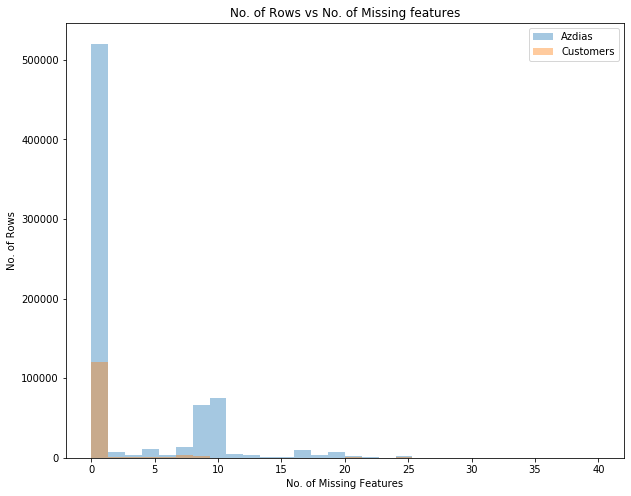

In [54]:
plot_missing_rowwise_histogram(azdias, customers)

As seen in the above plot we have successfully removed all the rows having more than 50 missing features. But, we still have some missing values in range of *1* to *50*. We can impute most common values of corresponding features in these rows, as the data represents the demographics of population. We can make an assumption that these missing values will be equal to the most common ones.

### <ins>0.1.3 Look at Column Types</ins>


We can look at the df.info() to understand what are the datatypes of the columns we have.

In [55]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737288 entries, 0 to 737287
Columns: 356 entries, LNR to Temp
dtypes: float64(266), int64(87), object(3)
memory usage: 2.0+ GB


In [56]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134246 entries, 0 to 134245
Columns: 359 entries, LNR to Temp
dtypes: float64(266), int64(88), object(5)
memory usage: 367.7+ MB


There are 3 columns with dtype- object in azdias and 5 columns in customers , we can look at the unique values in these columns.

In [57]:
azdias_cat_val = azdias.select_dtypes(include= ['object'])
customer_cat_val = customers.select_dtypes(include= ['object'])

In [58]:
att_info[att_info['Attribute'].isin (customer_cat_val)]

,Attribute,value_mean,Information level,Description,Additional notes
12,CAMEO_DEU_2015,"[(1A):Work-Life-Balance, (1B):Wealthy Best Ager, (1C):Successful Songwriter, (1D):Old Nobility, (1E):City Nobility, (2A):Cottage Chic, (2B):Noble Jogger, (2C):Established gourmet, (2D):Fine Management, (3A):Career & Family, (3B):Powershopping Families, (3C):Rural Neighborhood, (3D):Secure Retirement, (4A):Family Starter, (4B):Family Life, (4C):String Trimmer, (4D):Empty Nest, (4E):Golden Ager, (5A):Younger Employees, (5B):Suddenly Family, (5C):Family First, (5D):Stock Market Junkies, (5E):Coffee Rider, (5F):Active Retirement, (6A):Jobstarter, (6B):Petty Bourgeois, (6C):Long-established, (6D):Sportgardener, (6E):Urban Parents, (6F):Frugal Aging, (7A):Journeymen, (7B):Mantaplatte, (7C):Factory Worker, (7D):Rear Window, (7E):Interested Retirees, (8A):Multi-culteral, (8B):Young & Mobile, (8C):Prefab, (8D):Town Seniors, (9A):First Shared Apartment, (9B):Temporary Workers, (9C):Afternoon Talk Show, (9D):Mini-Jobber, (9E):Socking Away]",Microcell (RR4_ID),CAMEO_4.0: specific group,NaN
279,OST_WEST_KZ,"[(-1):unknown, (O):East (GDR), (W):West (FRG)]",Building,flag indicating the former GDR/FRG,NaN


In [59]:
azdias_cat_val.describe()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
count,734232,573216,737288
unique,45,35,2
top,6B,D19_UNBEKANNT,W
freq,54006,179081,582290


In [60]:
customer_cat_val.describe()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
count,134060,133313,134246,134246,134246
unique,45,35,2,3,2
top,2D,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
freq,10871,29592,123643,72410,94544


* **D19_LETZTER_KAUF_BRANCHE (45 Unique Values)** - contains information about the last branch they made a purchase. 
* **CAMEO_DEU_2015 (35 Unique Values)** - Gives information about specific group a person belongs to.

These, columns have too much granularity in information they represent. This will increase the number of features for modeling purposes. So these columns can also be dropped for simplicity.

In [61]:
remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]

azdias = remove_columns(azdias, remove_extra_cols)
customers = remove_columns(customers, remove_extra_cols)

* **OST_WEST_KZ** - It is flag indicating the former GDR/FRG. (O):East (GDR), (W):West (FRG)

We can encode values in this column with pd_dummies or a label encoder.

#### Encoding Categorical Columns

* Encoding *OST_WEST_KZ* column.

In [62]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

In [63]:
azdias = fix_ost_west_col(azdias)
customers = fix_ost_west_col(customers)

In [64]:
print('azdias shape: {} '.format(azdias.shape))
print('customers shape: {} '.format(customers.shape))

azdias shape: (737288, 354) 
customers shape: (134246, 357) 


Column `LNR` corresponds to id of each person and not a feature. We can futher confirm this by looking at the unique values in LNR column and the total number of rows in the dataframes.

In [65]:
len(azdias.LNR.unique()), len(azdias)

(737288, 737288)

In [66]:
# We can drop this column 

azdias = azdias.drop("LNR", axis=1)
customers = customers.drop("LNR", axis=1)

Seperating customers dataframe into two parts, i.e. taking out the extra columns present in customers dataset as a separate dataframe.

In [67]:
extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

customer_extra_cols = customers[extra_cols_in_customers]
customers = customers.drop(extra_cols_in_customers, axis = 1)

Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [68]:
azdias.shape, customers.shape, customer_extra_cols.shape

((737288, 353), (134246, 353), (134246, 3))

### <ins>0.1.4 Imputing Missing Values</ins>

Although we dropped columns and rows with missing values based on some threshold. We still have some columns having missing values. We can now address these missing values by either filling them with the most common values.

In this case, imputing missing values with most common values will make sense as this is demographic data and the values that are most common represent the population.

In [69]:
# Look at missing values table 
customer_missing_report = missing_values_table(customers)
azdias_missing_report = missing_values_table(azdias)

Your selected dataframe has 353 columns.
There are 66 columns that have missing values.
Your selected dataframe has 353 columns.
There are 68 columns that have missing values.


In [70]:
azdias_missing_report[azdias_missing_report['Missing_Percentage'] > 0]

,Attribute,Missing_Percentage
2,ALTERSKATEGORIE_FEIN,22.727075
29,D19_BANKEN_ONLINE_QUOTE_12,22.253448
84,D19_VERSI_ONLINE_QUOTE_12,22.253448
77,D19_VERSAND_ONLINE_QUOTE_12,22.253448
69,D19_TELKO_ONLINE_QUOTE_12,22.253448
61,D19_SOZIALES,22.253448
54,D19_LOTTO,22.253448
50,D19_KONSUMTYP,22.253448
46,D19_GESAMT_ONLINE_QUOTE_12,22.253448
346,W_KEIT_KIND_HH,7.370932


In [71]:
customer_missing_report[customer_missing_report['Missing_Percentage']>0]

,Attribute,Missing_Percentage
352,Temp,6.871713
296,LP_LEBENSPHASE_GROB,6.871713
295,LP_LEBENSPHASE_FEIN,6.871713
293,LP_FAMILIE_FEIN,6.565559
294,LP_FAMILIE_GROB,6.565559
346,W_KEIT_KIND_HH,5.463105
107,HH_DELTA_FLAG,4.806102
2,ALTERSKATEGORIE_FEIN,3.346841
318,RT_UEBERGROESSE,2.263755
104,GFK_URLAUBERTYP,2.254071


In [72]:
print (azdias.dtypes[azdias.isnull().sum() > 0])

ALTERSKATEGORIE_FEIN           float64
ANZ_HH_TITEL                   float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                      float64
CJT_TYP_5                      float64
CJT_TYP_6                      float64
D19_BANKEN_ONLINE_QUOTE_12     float64
D19_GESAMT_ONLINE_QUOTE_12     float64
D19_KONSUMTYP                  float64
D19_LOTTO                      float64
D19_SOZIALES                   float64
D19_TELKO_ONLINE_QUOTE_12      float64
D19_VERSAND_ONLINE_QUOTE_12    float64
D19_VERSI_ONLINE_QUOTE_12      float64
EWDICHTE                       float64
FIRMENDICHTE                   float64
GEBAEUDETYP_RASTER             float64
GEMEINDETYP              

In [73]:
print (customers.dtypes[customers.isnull().sum() > 0])

ALTERSKATEGORIE_FEIN           float64
ANZ_HH_TITEL                   float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                      float64
CJT_TYP_5                      float64
CJT_TYP_6                      float64
D19_BANKEN_ONLINE_QUOTE_12     float64
D19_GESAMT_ONLINE_QUOTE_12     float64
D19_KONSUMTYP                  float64
D19_LOTTO                      float64
D19_SOZIALES                   float64
D19_TELKO_ONLINE_QUOTE_12      float64
D19_VERSAND_ONLINE_QUOTE_12    float64
D19_VERSI_ONLINE_QUOTE_12      float64
EWDICHTE                       float64
GEMEINDETYP                    float64
GFK_URLAUBERTYP                float64
HEALTH_TYP               

In [74]:
# We will fit the imputer on the azdias data and then transform both azdias and customers data.

imputer = SimpleImputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [75]:
# Look at missing values table 
customer_missing_report = missing_values_table(customers)
azdias_missing_report = missing_values_table(azdias)

Your selected dataframe has 353 columns.
There are 0 columns that have missing values.
Your selected dataframe has 353 columns.
There are 0 columns that have missing values.


In [76]:
azdias.shape, customers.shape, customer_extra_cols.shape

((737288, 353), (134246, 353), (134246, 3))

In [77]:
# Saving cleaned dataframes to load them directly again.

azdias_cleaned = azdias.copy()
customers_cleaned = customers.copy()


azdias_cleaned.to_csv('./Data/Cleaned_Data/Azdias_cleaned.csv', index=False)
customers_cleaned.to_csv('./Data/Cleaned_Data/Customers_cleaned.csv', index=False)
customer_extra_cols.to_csv('./Data/Cleaned_Data/Customer_Additional_cleaned.csv', index=False)

### <ins>0.1.5 Feature Scaling</ins>

After cleaning the data, we can now scale the data to make sure all the features have the same range. We are going to use StandardScaler from sklearn to scale the data.

In [78]:
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [79]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAG

In [80]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAG

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### <ins>1.1 Dimensionality Reduction</ins>

As the number of features in the data is relatively high, we can verify the variance explained by each feature in the dataset. By using a dimensionality reduction technique, we can effectively reduce the number of features which do not vary much in the data. Since we cannot go through each and every feature ourselves to decide if the feature is varying, we can use a statistical approach to find how much variance is explained by each feature. One such algorithm is Principal Component Analysis(PCA). 

In [81]:
# First, we must fit our standardized data using PCA.

pca = PCA(n_components=None, random_state=42)
pca_azdias = pca.fit(azdias)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot 
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca) 

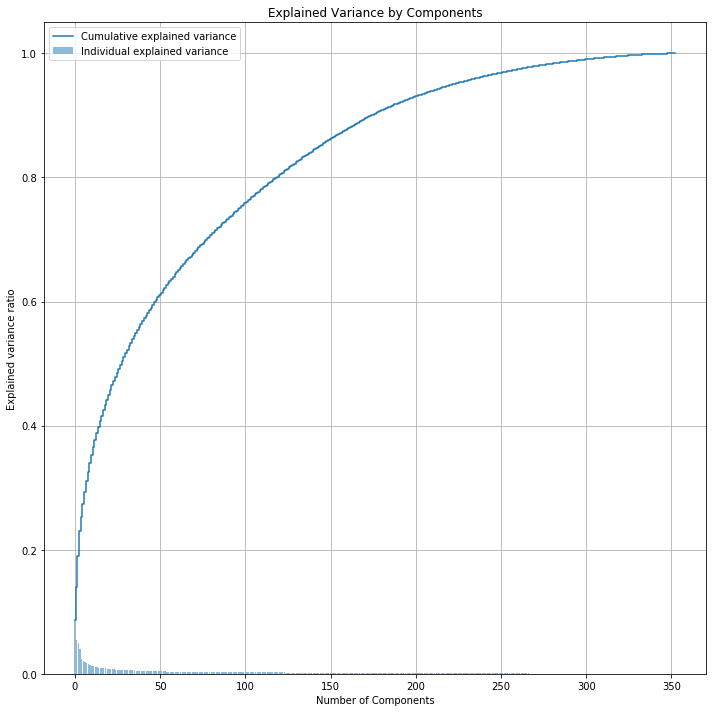

In [82]:
# Create the visualization plot

plt.figure(figsize=(10,10))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.title('Explained Variance by Components')
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.show()

**We need to decide how many features we’d like to keep based on the cumulative variance plot.**
The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. **So, in this instance, we decide to keep 150 components.**

In [83]:
# We perform PCA with the chosen number of components.

pca = PCA(n_components=150, random_state=42) # We choose 150 components
pca_azdias_150 = pca.fit(azdias) # Fit the model the our data wtih selected number of components


# Calculated resulting components scores for the elements in our data set
scores_pca = pca_azdias_150.transform(azdias)


We’ll incorporate the newly obtained PCA scores in the K-means algorithm. That's how we can perform segmentation based on principal components scores instead of the original features.

### <ins>1.2 Interpreting PCA Components</ins>

We can now look at the feature weights given by the PCA algorithm and understand what each component is comprised of. We can write a function to get information about the top n positive features and top n negative features for a given component.

In [84]:
def plot_feature_weights(df, pca, att_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in att_info.Attribute.values:
            feat_descs.append(att_info[att_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

### Component 0

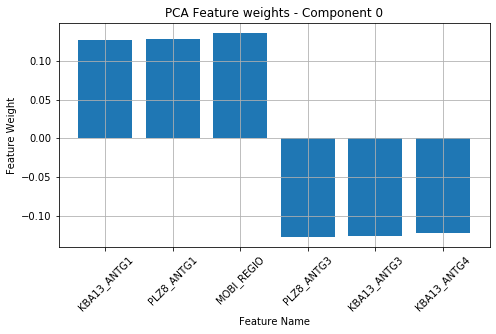

,Feature,Description,FeatureWeight
0,MOBI_REGIO,moving patterns,0.136078
1,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.128497
2,KBA13_ANTG1,No description given,0.127879
3,KBA13_ANTG4,No description given,-0.122913
4,KBA13_ANTG3,No description given,-0.126740
5,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.127398


In [85]:
component_0_info = plot_feature_weights(azdias, pca_azdias_150, att_info, 0, 3)
component_0_info.head(10)

**Component 0:**
* Has a high positive weight to moving patterns of people.
* Has a high weight to number of 1-2 family houses in the neighbourhood and a negative weight to number of 6-10 family houses.
* KBA13_* - this feature has no description given (in Attributes - levels data), but some similar features (which have a description) correspond to shares of cars with some specification. 

### Component 1

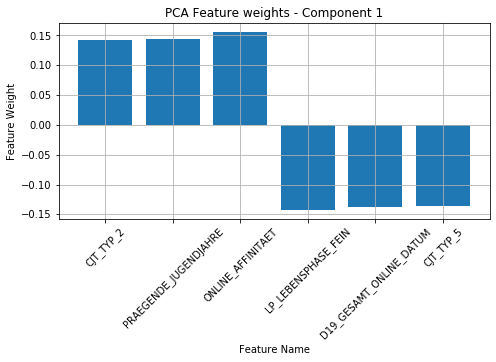

,Feature,Description,FeatureWeight
0,ONLINE_AFFINITAET,online affinity,0.155719
1,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),0.144450
2,CJT_TYP_2,No description given,0.141812
3,CJT_TYP_5,No description given,-0.135806
4,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the complete file ONLINE,-0.137410
5,LP_LEBENSPHASE_FEIN,lifestage fine,-0.142993


In [86]:
component_1_info = plot_feature_weights(azdias, pca_azdias_150, att_info, 1, 3)
component_1_info.head(10)

**Component 1:**
* Has a high positive weights towards features describing online activity and transactions of last 12 and 24 months.
* Has a negative weight to features containing information about when was the last transaction made.

### Component 2

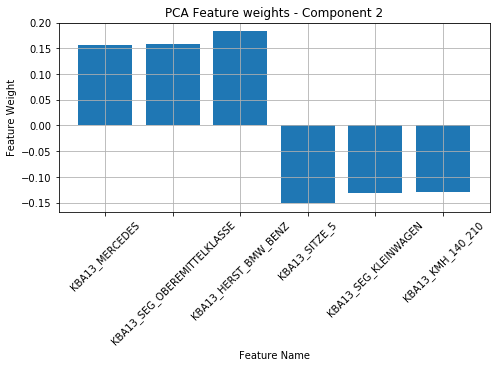

,Feature,Description,FeatureWeight
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.183428
1,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",0.158358
2,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.156985
3,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,-0.129018
4,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8",-0.131351
5,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.151226


In [87]:
component_2_info = plot_feature_weights(azdias, pca_azdias_150, att_info, 2, 3)
component_2_info.head(10)

**Component 2:**
* Has a high positive weights towards features that have information about upper class car's shares.
* Has a negative weight to features that have information about lower class cars's share.


### Component 3

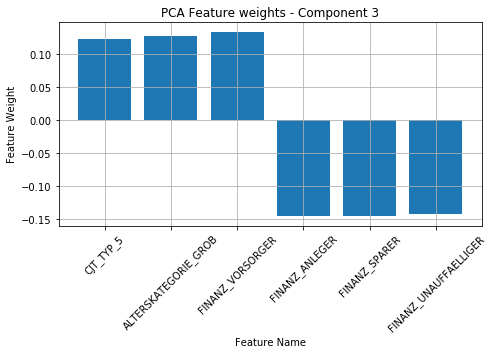

,Feature,Description,FeatureWeight
0,FINANZ_VORSORGER,financial typology: be prepared,0.134542
1,ALTERSKATEGORIE_GROB,age through prename analysis,0.128589
2,CJT_TYP_5,No description given,0.122930
3,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,-0.141870
4,FINANZ_SPARER,financial typology: money saver,-0.145299
5,FINANZ_ANLEGER,financial typology: investor,-0.145914


In [88]:
component_3_info = plot_feature_weights(azdias, pca_azdias_150, att_info, 3, 3)
component_3_info.head(10)

**Component 3:**
* This component corresponds to people who are always financially prepared.
* This component has a negative weight to people who save money or invest money.
* Also the age determined through prename analysis has a big impact on this component.
* The movement a person witnessed/participated during their youth has a negative weight on this component.

### Component 4

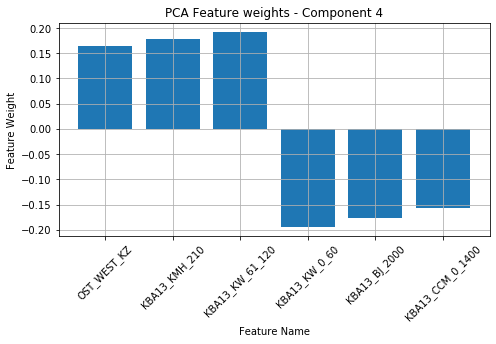

,Feature,Description,FeatureWeight
0,KBA13_KW_61_120,share of cars with an engine power between 61 and 120 KW - PLZ8,0.191278
1,KBA13_KMH_210,No description given,0.178460
2,OST_WEST_KZ,flag indicating the former GDR/FRG,0.165263
3,KBA13_CCM_0_1400,share of cars with less than 1401ccm within the PLZ8,-0.156377
4,KBA13_BJ_2000,share of cars built between 2000 and 2003 within the PLZ8,-0.176673
5,KBA13_KW_0_60,share of cars with less than 61 KW engine power - PLZ8,-0.193341


In [89]:
component_4_info = plot_feature_weights(azdias, pca_azdias_150, att_info, 4, 3)
component_4_info.head(10)

**Component 4:**
* People with share of cars with less than 61KW engine has highest negative weight and cars with engine power between 61 and 120KW has highest positive weight.
* The origins of the person i.e. where they belonged before German unification is also having a positive weight.
* Some other car specifications are playing an impact on this component.

We can further look into all the 150 components that PCA has and analyse what each component represents.

### <ins>1.3 Combine PCA and K-means Clustering</ins>

Combine PCA and K-means to segment our data, where we use the scores obtained by the PCA for the fit. 
We ourselves need to determine the number of clusters in a K-means algorithm. 
In order to do so, we run the algorithm with a different number of clusters. Then, we determine the Within Cluster Sum of Squares or WCSS for each solution. Based on the values of the WCSS and an approach known as the Elbow method, we make a decision about how many clusters we’d like to keep.

### First, however, we must decide how many clustering solutions we’d test.
There is no general ruling on this issue. It really depends on the data. In our case, we test an algorithm with up to 20 clusters.

In [90]:
# We perform PCA with the chosen number of components.

pca = PCA(n_components=150, random_state=42) # We choose 150 components
pca_azdias_150 = pca.fit(azdias) # Fit the model the our data wtih selected number of components


# Calculated resulting components scores for the elements in our data set
scores_pca = pca_azdias_150.transform(azdias)


In [92]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for i in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", i)
        start = time.time()
        
        kmeans_pca = KMeans(n_clusters = i , init = "k-means++" , random_state = 42)
        kmeans_pca.fit(scores_pca)
        scores.append(kmeans_pca.inertia_)
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [91]:
%%time
scores, range_ = get_Kmeans_scores(scores_pca, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  207364277.57795593
Time elapsed: 68.76 sec.

Training for n_clusters:  3
Done! Score:  199634961.514558
Time elapsed: 106.86 sec.

Training for n_clusters:  4
Done! Score:  195276080.71905434
Time elapsed: 191.42 sec.

Training for n_clusters:  5
Done! Score:  191506048.99828666
Time elapsed: 251.98 sec.

Training for n_clusters:  6
Done! Score:  188568645.19594312
Time elapsed: 288.06 sec.

Training for n_clusters:  7
Done! Score:  186145253.1194345
Time elapsed: 257.17 sec.

Training for n_clusters:  8
Done! Score:  184042488.75283852
Time elapsed: 334.28 sec.

Training for n_clusters:  9
Done! Score:  182265252.19041002
Time elapsed: 1824.96 sec.

Training for n_clusters:  10
Done! Score:  180887826.2130752
Time elapsed: 386.79 sec.

Training for n_clusters:  11
Done! Score:  179657645.3883161
Time elapsed: 580.00 sec.

Training for n_clusters:  12
Done! Score:  178563302.71887

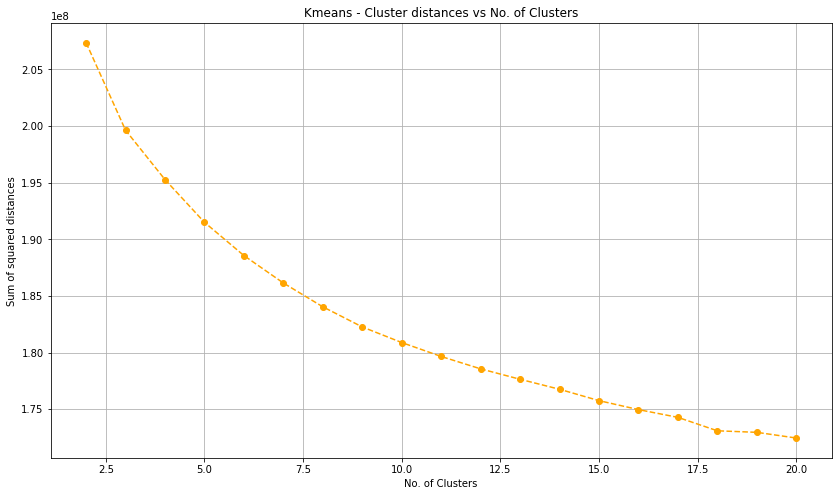

In [92]:
# Involves plotting the scores against the number of components on a graph.

def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    plt.grid()
    plt.show()
    
plot_elbow(scores, range_)

And from this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the graph. 

The idea behind the elbow method, is that the number of clusters can be selected in such a way that adding one more cluster to the existing clusters will not improve the intra-cluster variation. Which means adding a cluster will not reduce the sum of sqaured distances between the clusters. 

From the elbow above, we can see that the sum of sqaured error decreasing with a high slope until around **7** clusters and then the slope decreases.

In [93]:
# We have chosen 7 clusters, so we run K-means with the number pf clusters equals seven.
# Some initializer and random state as before 

kmeans_pca = KMeans(n_clusters = 7 , init = 'k-means++', random_state = 42)

# We fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [94]:
# We predict azdias and customers datasets

azdias_clusters = kmeans_pca.predict(scores_pca) # predict azdias dataset

customers_pca_150 = pca_azdias_150.transform(customers) # Calculated resulting components scores for the elements in customer data set
customers_clusters = kmeans_pca.predict(customers_pca_150) # predict customers dataset

In [95]:
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [96]:
customers_clusters.value_counts().sort_index()

0    30871
1    43527
2    1398 
3    3148 
4    16527
5    35405
6    3370 
dtype: int64

In [97]:
azdias_clusters.value_counts().sort_index()

0    73494 
1    126815
2    119519
3    103925
4    108533
5    135032
6    69970 
dtype: int64

In [98]:
# The Number of people coming under each cluster can be stored in a dataframe for further analysis.

cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [99]:
cluster_info

,Cluster,Population,Customers
0,0,73494,30871
1,1,126815,43527
2,2,119519,1398
3,3,103925,3148
4,4,108533,16527
5,5,135032,35405
6,6,69970,3370


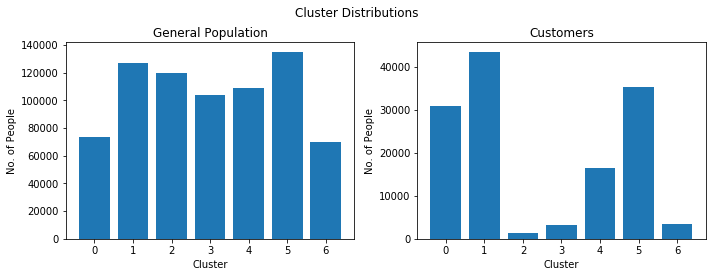

In [100]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### How much percentage of population under consideration is present in each cluster.

In [101]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

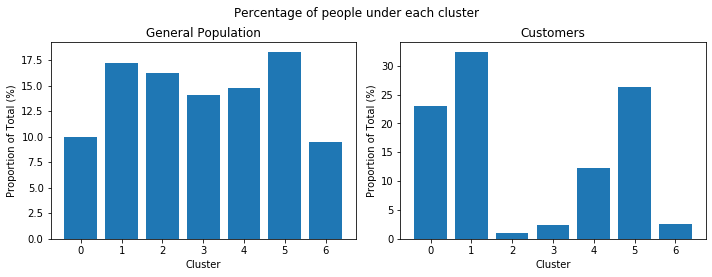

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Pop_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Cust_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* The distribution of general population is close to uniform (although not perfectly uniform).
* The customers are mostly from clusters 0, 1, 5.

### Ratio of Proportion of Customers to Proportion of General Population in each cluster

Ratio of customers proportion to general population proportion in each cluster. This gives an idea of which clusters are the customers of the mail order company from and where can the company acquire its new customers from. For example if the ratio of customers proportion to population proportion in one cluster is more than one. Then it is more likely that there is a chance that people from that cluster becoming future customers.

In [103]:
cluster_info["Cust_over_Pop"] = cluster_info["Cust_proportion"] / cluster_info["Pop_proportion"]

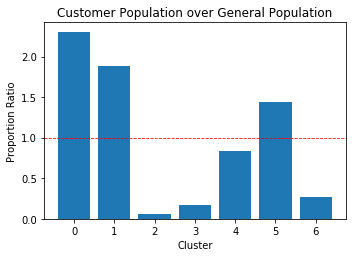

In [104]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(cluster_info["Cluster"], cluster_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8 , color = 'red')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The *ratio > 1* indicates that the cluster contains more customers, and there is a scope of the people belonging to these clusters being future customers.

* The ratio between proportions of customers and population gave an idea about what proportion of customers are there in each cluster.
* This also gives an idea about which cluster can be targetted for future customers.
* In this context, cluster 0,1 and 5 could be targetted for future new customers.

### What does each cluster represent?

To answer this we can see which pca component influences a given cluster most and then identifying which feature influences that pca component. This is done by the following function.

In [105]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, att_info, num_components=2, num_feat_per_comp=3):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True, ignore_index=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, att_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [106]:
cluster_0 = explain_cluster(kmeans_pca, 0, azdias, pca, att_info)
cluster_0

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,2,6.181089,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.183428
1,2,6.181089,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",0.158358
2,2,6.181089,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.156985
3,2,6.181089,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,-0.129018
4,2,6.181089,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8",-0.131351
5,2,6.181089,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.151226
6,0,1.689366,MOBI_REGIO,moving patterns,0.136078
7,0,1.689366,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.128497
8,0,1.689366,KBA13_ANTG1,No description given,0.127879
9,0,1.689366,KBA13_ANTG4,No description given,-0.122913


In [107]:
cluster_1 = explain_cluster(kmeans_pca, 1, azdias, pca, att_info)
cluster_1

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,3.857026,MOBI_REGIO,moving patterns,0.136078
1,0,3.857026,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.128497
2,0,3.857026,KBA13_ANTG1,No description given,0.127879
3,0,3.857026,KBA13_ANTG4,No description given,-0.122913
4,0,3.857026,KBA13_ANTG3,No description given,-0.126740
5,0,3.857026,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.127398
6,9,0.464738,KBA13_ALTERHALTER_45,share of car owners between 31 and 45 within the PLZ8,0.163921
7,9,0.464738,KBA13_CCM_1401_2500,No description given,0.161721
8,9,0.464738,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,0.160309
9,9,0.464738,KBA13_HHZ,No description given,-0.145228


In [108]:
cluster_5 = explain_cluster(kmeans_pca, 1, azdias, pca, att_info)
cluster_5

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,3.857026,MOBI_REGIO,moving patterns,0.136078
1,0,3.857026,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.128497
2,0,3.857026,KBA13_ANTG1,No description given,0.127879
3,0,3.857026,KBA13_ANTG4,No description given,-0.122913
4,0,3.857026,KBA13_ANTG3,No description given,-0.126740
5,0,3.857026,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.127398
6,9,0.464738,KBA13_ALTERHALTER_45,share of car owners between 31 and 45 within the PLZ8,0.163921
7,9,0.464738,KBA13_CCM_1401_2500,No description given,0.161721
8,9,0.464738,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,0.160309
9,9,0.464738,KBA13_HHZ,No description given,-0.145228


* From the above printed dataframes, we can conclude what kind of people constitute in each cluster. And what characteristics correspond to each cluster can also be understood at a greater detail.

* This analysis helps in understanding the existing customers and their behaviour according to demographics and other data collected.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [109]:
mailout_train = pd.read_csv('./Data/mailout_train.csv')

C:\Users\Mustafa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [110]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [111]:
mailout_train.shape

(42962, 367)

0    42430
1    532  
Name: RESPONSE, dtype: int64


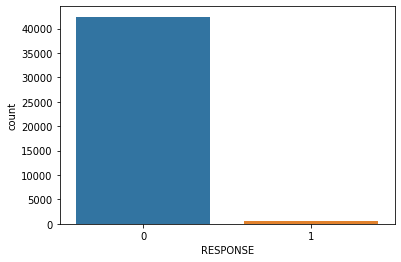

In [112]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

### <ins>2.1. Selecting the Evaluation Metric</ins>

The data is highly imbalanced. We have more thn 40 thousand - `0` responses and only 532 - `1` responses. Accuracy will be a bad metric to choose for this problem since the accuracy might always be more than 98% even if the model predicts all zeros. Since `42430/(42430+532)*100 = 98.7 %`. So, even if the model predicts zero for all the data points we will end up with having accuracy 98.7% which does not make sense in this case.

To address this imbalance while evaluating the model we need to chose a metric which will take this class imbalance into accounts. The usual metrics used for imbalanced classification are *Precision and Recall* or *Area under Receiver Operating Curve (AUROC)*. 

Before understanding what these two metrics mean and how they are calculated we need to understand the basics of confusion matrix.

* Confusion Matrix: is a `2x2` matrix in case of binary classification problems which shows the number of values predicted correctly and the number of values predicted wrongly. The confusion matrix is the base for any classification metric, even accuracy can be calculated from the values inside confusion matrix.

Terms inside confusion matrix:
* **True Positives (TP)** - Number of positive observations predicted as positive
* **True Negatives (TN)** - Number of negative observations predicted as negative
* **False Negatives (FN)** - Number of positive observations predicted as negative
* **False Positives (FP)** - Number of negative observations predicted as positive


**Precision and Recall**:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)

**ROC curve**
* True Positive Rate = TP / (TP + FN)
* False Positive Rate = FP / (FP + TN)

From the formulae above we can intuitively understand that recall and precision are concentrated towards positive examples i.e. if we care about the performance on the positive examples we can choose these metrics. ([Shir Meir Lador
](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba))

But ROC metrics are able to measure the ability of the model to distinguish between classes i.e. these metrics take into account the predictions of both classes into account.  ([Shir Meir Lador
](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recal-roc-e2e79252aeba))

For this problem, we need to be able to tell whether a person will be a future possible customer. AUROC metric which considers both true positive rate and false positive rate seem to be a good choice for this problem, since we want to be able to correctly predict both cases i.e. whether a person becomes a customer or not. Since, Both these predictions are important for us.


### <ins>2.2. Cleaning data for Modelling</ins>

Before trying out different models, we should also preprocess the data given here. We will follow the same cleaning steps we performed for the customers and general population data here.

In [113]:
def clean_data_for_supervised(df, attributes_values):
    
    print("Cleaning Given Dataframe")
    
    start = time.time()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])
        
    # Ignore if these cols are already cleaned 
    if not (df[warning_cols[0]].dtype == 'float64') & (df[warning_cols[1]].dtype == 'float64'):
        df = fix_warning_cols(df)
        
        
    print("\tFixing LP_* columns")
    df = fix_LP_cols(df)
    
    print("\tFixing EINGEFUGT column")
    df = fix_eigefugt_col(df)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attribute[attribute["Meaning"] == "unknown"]
    
    df = replace_unkowns(df, unkown_attributes_values, verbose=False)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    df = fix_ost_west_col(df)
       
    # Dropping columns which are not in azdias
    print("\tDropping extra columns")
    cols_to_drop = [col for col in df.columns if col not in azdias.columns]   
    df = remove_columns(df, cols_to_drop)
    
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")
    
    imputer.fit(azdias)
    df = pd.DataFrame(imputer.transform(df), columns = df.columns)
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return df

In [114]:
labels = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

In [115]:
mailout_train = clean_data_for_supervised(mailout_train, attribute)

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding OST_WEST_KZ column
	Dropping extra columns
	Imputing missing values with most frequent ones
Completed Cleaning in 32.26529288291931 seconds


In [116]:
mailout_train.shape

(42962, 353)

In [117]:
azdias.shape

(737288, 353)

In [118]:
labels

0        0
1        0
2        0
3        0
4        0
        ..
42957    0
42958    0
42959    0
42960    0
42961    0
Name: RESPONSE, Length: 42962, dtype: int64

### <ins>2.3. Setting The Benchmark</ins>

Training a Logistic regression model on unscaled data to set a benchmark performance that we aim to improve upon.

In [119]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=42)

In [120]:
lr = LogisticRegression(random_state=42)

In [121]:
lr.fit(X_train, y_train)

C:\Users\Mustafa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [122]:
pred = lr.predict_proba(X_val)[:,1]
pred

array([0.01245443, 0.05054239, 0.00855751, ..., 0.00992969, 0.00200583,
       0.00170284])

In [123]:
print("Baseline AUROC - ", roc_auc_score(y_val, pred))

Baseline AUROC -  0.7094713112840727


The baseline score we achieved with unscaled data with logistic regression is 0.61.

Now, we are going to try different models and tr to improve upon this score.

### <ins>2.4. Trying out Different Models</ins>


#### Scaling data

In [124]:
scaler = StandardScaler()

mailout_train = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

#### Split dataset into train and test

In [125]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=42)

In [126]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed    

In [127]:
models = [("LogisticRegression", LogisticRegression(random_state=42)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=42)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=42)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=42))]

In [128]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

C:\Users\Mustafa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mustafa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [129]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.705207,7.663273
1,DecisionTreeClassifier,0.530768,2.150944
2,RandomForestClassifier,0.529624,0.933848
3,GradientBoostingClassifier,0.770361,34.355169
4,AdaBoostClassifier,0.739097,11.226082
5,XGBClassifier,0.774917,15.082459


Looking at the scores above `XGBClassifier`, `GradientBoostingClassifier` and `AdaBoostClasifier` have the highest score, but `GradientBoostingClassifier` is the slowest to train. Also **XGBClassifier** and **AdaBoostClasifier** take less time to train. So we are going to select these algorithms for hyper parameter tuning.


Before starting hyper parameter tuning, we can also try reducing number of dimensions to see whether that helps to improve performance.

In [130]:
mailout_train_reduced = pca_azdias_150.transform(mailout_train)

X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(mailout_train_reduced, labels,
                                                                  stratify=labels, test_size=0.2, random_state=42)

In [131]:
models = [("LogisticRegression", LogisticRegression(random_state=42)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=42)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=42)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=42))]

results_reduced = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train_red, y_train_red, X_val_red, y_val_red)
    results_reduced["Model"].append(name)
    results_reduced["AUCROC_score"].append(roc)
    results_reduced["Time_in_sec"].append(time_)
    
results_reduced = pd.DataFrame.from_dict(results_reduced, orient='index').transpose()
results_reduced

C:\Users\Mustafa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mustafa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.691185,1.504975
1,DecisionTreeClassifier,0.509598,21.82563
2,RandomForestClassifier,0.497606,5.897229
3,GradientBoostingClassifier,0.61999,42.587923
4,AdaBoostClassifier,0.566825,25.895155
5,XGBClassifier,0.65262,20.121897


The dimensionality reduction seems to not help here. We will continue with the data with all the columns from here on.

###  <ins>2.5 Grid Search</ins>

### AdaBoostClassifier

In [132]:
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=42), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [133]:
%%time
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.2min finished


Best Score:  0.7643873727535121
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
Wall time: 12min 34s


In [134]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7725


In [135]:
param_grid = {"n_estimators": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 30, 40, 50],
              "learning_rate": [(0.97 + x / 100) for x in range(0, 8)],
              "algorithm":['SAMME', 'SAMME.R']
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=42), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [136]:
%%time
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 18.0min finished


Best Score:  0.7684649746743456
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.97, 'n_estimators': 9}
Wall time: 18min 3s


In [137]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7664


### XGB Classifier Parameter Tuning

In [133]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    # ax.set_title(f'Feature Importances ({model_name})') 

In [134]:
# Define a function which will help us create XGBoost models and perform cross-validation. 

def modelfit(alg, X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    '''
    alg: model in which we determine hyper parameter variables and want to measure performance
    X_train: Train dataset 
    y_train: Target variable of train dataset
    X_test: Test dataset
    y_test: Target variable of test dataset
    
    useTrainCV: This works only if the useTrainCV argument of the function is set as True. 
                If True, this will run “xgb.cv”, determine the optimal value for n_estimators 
                and replace the value set by the user with this value.
    '''
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=["auc"], early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
  

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : {:.4f}".format(accuracy_score(y_train, alg.predict(X_train))))
    print ("AUC Score (Train): {:.4f}".format(roc_auc_score(y_train, alg.predict_proba(X_train)[:,1])))
    print ("AUC Score (Test): {:.4f}".format(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1])))
    print("Set_Params: ", alg.set_params)


    plot_feature_importances(alg, model_name=alg, feature_names=mailout_train.columns)


####  Learning rate and number of estimators for tuning tree-based parameters

Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. 


Model Report
Accuracy : 0.9876
AUC Score (Train): 0.8076
AUC Score (Test): 0.7649
Set_Params:  <bound method XGBModel.set_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=16, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)>


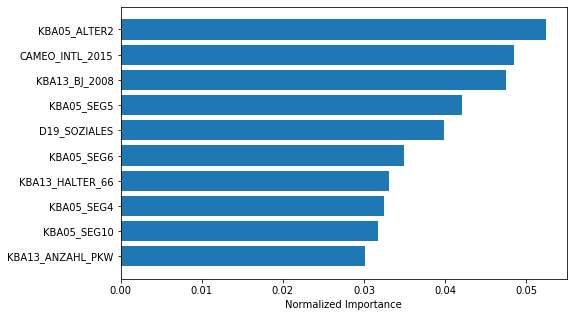

In [140]:
xgb1 = xgb.XGBClassifier(learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1,
                         seed=42)

modelfit(xgb1,X_train, X_val, y_train, y_val)

We see that here we got 16 as the optimal estimators for 0.1 learning rate.

#### Tune max_depth and min_child_weight

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

- 'max_depth':range(3,10,2),
- 'min_child_weight':range(1,6,2)

In [141]:
param_test1 = {'max_depth':range(3,10,2),
               'min_child_weight':range(1,6,2)
              }

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=16,  
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=42), 
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs = -1,
                        cv=5,
                        verbose=2)
                        
                     
gsearch1.fit(X_train, y_train)
best_xgb = gsearch1.best_estimator_


preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("Best Score: ", gsearch1.best_score_)
print("Best Params: ", gsearch1.best_params_)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


Best Score:  0.7607507753525504
Best Params:  {'max_depth': 9, 'min_child_weight': 5}
ROC score on validation data: 0.7742


The ideal values are **9 for max_depth** and **5 for min_child_weight**. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [142]:
param_test1 = {'max_depth': [8,9,10],
               'min_child_weight': [4,5,6]
              }

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=16,  
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=42), 
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs = -1,
                        cv=5,
                        verbose=2)
                        
                     
gsearch1.fit(X_train, y_train)
best_xgb = gsearch1.best_estimator_


preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("Best Score: ", gsearch1.best_score_)
print("Best Params: ", gsearch1.best_params_)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


Best Score:  0.760865562970053
Best Params:  {'max_depth': 9, 'min_child_weight': 6}
ROC score on validation data: 0.7692


We get the optimum values as **9 for max_depth** and **6 for min_child_weight.** Also, we can see the CV score increasing slightly.
We got 6 as optimum value for min_child_weight but we haven’t tried values more than 6. We can do that as follow:

In [143]:
param_test1 = {
               'min_child_weight': [6,8,10,12]
              }

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                      n_estimators=16, 
                                                      max_depth = 9,
                                                      gamma=0, 
                                                      subsample=0.8, 
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1, 
                                                      seed=42), 
                        
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs = -1,
                        cv=5,
                        verbose=2)
                        
                     
gsearch1.fit(X_train, y_train)
best_xgb = gsearch1.best_estimator_


preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("Best Score: ", gsearch1.best_score_)
print("Best Params: ", gsearch1.best_params_)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   23.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.3s finished


Best Score:  0.760865562970053
Best Params:  {'min_child_weight': 6}
ROC score on validation data: 0.7692


We see 6 as the optimal value.

#### Tune gamma

Lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here.

-'gamma':[i/10.0 for i in range(0,5)]

In [144]:
param_test1 = {
               'gamma':[i/10.0 for i in range(0,5)]
              }

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                      n_estimators=16, 
                                                      max_depth = 9,
                                                      min_child_weight = 6,
                                                      
                                                      subsample=0.8, 
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1, 
                                                      seed=42), 
                        
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs = -1,
                        cv=5,
                        verbose=2)
                        
                     
gsearch1.fit(X_train, y_train)
best_xgb = gsearch1.best_estimator_


preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("Best Score: ", gsearch1.best_score_)
print("Best Params: ", gsearch1.best_params_)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   36.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   38.2s finished


Best Score:  0.7614731782829628
Best Params:  {'gamma': 0.1}
ROC score on validation data: 0.7691


**0 is the optimum one.** Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.


Model Report
Accuracy : 0.9876
AUC Score (Train): 0.8305
AUC Score (Test): 0.7709
Set_Params:  <bound method XGBModel.set_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=None, n_estimators=15, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)>


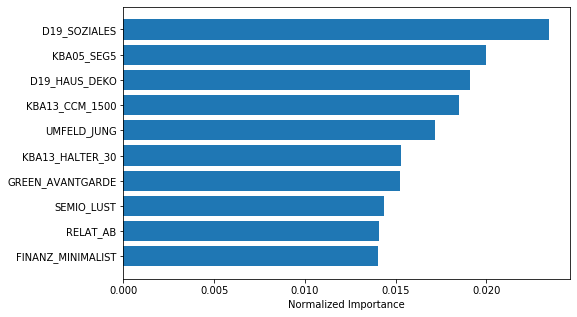

In [145]:
xgb2 = xgb.XGBClassifier(learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=9,
                         min_child_weight=6,
                         gamma=0.1,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1,
                         seed=42)

modelfit(xgb2,X_train, X_val, y_train, y_val)

Here, we can see the improvement in score. So the final parameters are:

- learning_rate =0.1
- n_estimators=15
- max_depth=9
- min_child_weight=6
- gamma=0.1

#### Tune subsample and colsample_bytree

The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with

In [146]:
param_test1 = {
               'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]
              }

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                      n_estimators=15, 
                                                      max_depth = 9,
                                                      min_child_weight = 6,
                                                      gamma=0.1,
                                                      
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1, 
                                                      seed=42), 
                        
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs = -1,
                        cv=5,
                        verbose=2)
                        
                     
gsearch1.fit(X_train, y_train)
best_xgb = gsearch1.best_estimator_


preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("Best Score: ", gsearch1.best_score_)
print("Best Params: ", gsearch1.best_params_)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.7min finished


Best Score:  0.7673331730275983
Best Params:  {'colsample_bytree': 0.9, 'subsample': 0.8}
ROC score on validation data: 0.7739


We found **0.9 for colsample_bytree** and **0.8 for subsample** as the optimum value. 

**Tuning Regularization Parameters**

Next step is to apply regularization to reduce overfitting. 

- 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]

In [147]:
param_test1 = {
               'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
              }

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                      n_estimators=15, 
                                                      max_depth = 9,
                                                      min_child_weight = 6,
                                                      gamma=0.1,
                                                      subsample = 0.8,
                                                      colsample_bytree = 0.9,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1, 
                                                      seed=42), 
                        
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs = -1,
                        cv=5,
                        verbose=2)
                        
                     
gsearch1.fit(X_train, y_train)
best_xgb = gsearch1.best_estimator_


preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("Best Score: ", gsearch1.best_score_)
print("Best Params: ", gsearch1.best_params_)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   37.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   39.5s finished


Best Score:  0.7675659190550559
Best Params:  {'reg_alpha': 0.05}
ROC score on validation data: 0.7758


We can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:


Model Report
Accuracy : 0.9876
AUC Score (Train): 0.8244
AUC Score (Test): 0.7763
Set_Params:  <bound method XGBModel.set_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=None, n_estimators=14, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)>


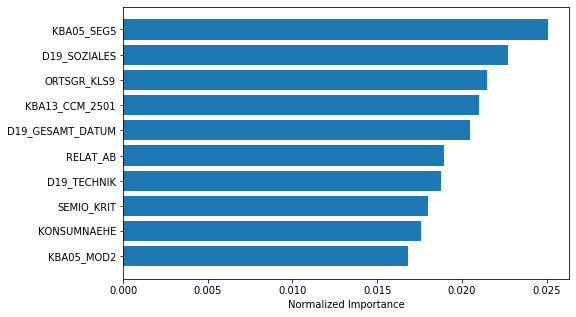

In [148]:
xgb3 = xgb.XGBClassifier(learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=9,
                         min_child_weight=6,
                         gamma=0.1,
                         subsample=0.8,
                         colsample_bytree=0.9,
                         reg_alpha=0.05,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1,
                         seed=42)

modelfit(xgb3,X_train, X_val, y_train, y_val)

we can see slight improvement in the score.

#### Reducing Learning Rate

astly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.


Model Report
Accuracy : 0.9876
AUC Score (Train): 0.9043
AUC Score (Test): 0.7855
Set_Params:  <bound method XGBModel.set_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=None, n_estimators=76, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)>


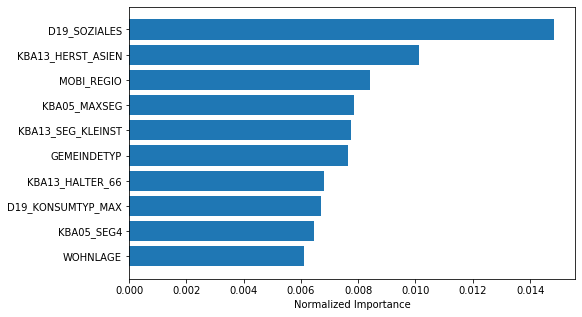

In [149]:
xgb4 = xgb.XGBClassifier(learning_rate =0.05,
                         n_estimators=5000,
                         max_depth=9,
                         min_child_weight=6,
                         gamma=0.1,
                         subsample=0.8,
                         colsample_bytree=0.9,
                         reg_alpha=0.05,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1,
                         seed=42)

modelfit(xgb4,X_train, X_val, y_train, y_val)

### <ins>2.6 Select Final Model</ins>

As we see above lines, **xgb4** model has the highest AUC Test Score (0.7855). So, we select **XGB Classifier** model with final parameters below mentioned;


- learning_rate =0.05,
- n_estimators=76
- max_depth=9
- min_child_weight=6
- gamma=0.1
- subsample=0.8
- colsample_bytree=0.9
- reg_alpha=0.05
- objective= 'binary:logistic'
- nthread=4
- scale_pos_weight=1
- seed=42


Model Report
Accuracy : 0.9876
AUC Score (Train): 0.9043
AUC Score (Test): 0.7855
Set_Params:  <bound method XGBModel.set_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=None, n_estimators=76, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)>


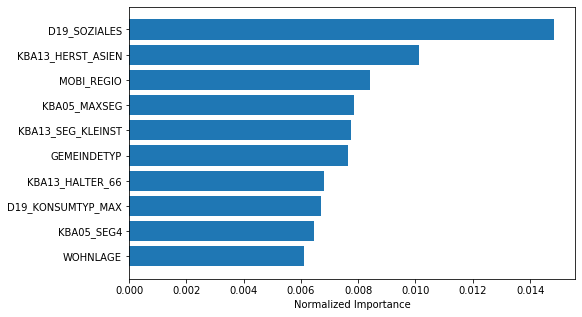

In [135]:
final_model = xgb.XGBClassifier(learning_rate =0.05,
                         n_estimators=5000,
                         max_depth=9,
                         min_child_weight=6,
                         gamma=0.1,
                         subsample=0.8,
                         colsample_bytree=0.9,
                         reg_alpha=0.05,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1,
                         seed=42)

modelfit(final_model,X_train, X_val, y_train, y_val)

In [136]:
params_final = final_model.set_params()
print(params_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=None, n_estimators=76, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)


### <ins>2.7 Extras (Look at Final Model Optimal Thresholds and Confusion Matrix)</ins>

Final Model XGB Classifier predicts a probability between 0 and 1 for the unseen cases. Further, it predicts 0 and 1 by putting a threshold at 0.5 by default (1 if probability > 0.5). In unbalance data-set as in here, it may be a biased setting as it would be difficult to capture rare event with 0.5 threshold.

- We can change the by default threshold of 0.5 by finding the optimal threshold to increase AUC score.
- We need to find the threshold where AUC score is highest.
- I tried submissions on few optimal cut-offs to get maximum possible improved AUC score.

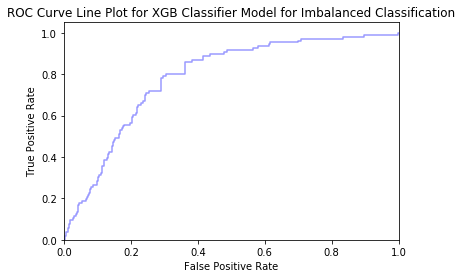

In [249]:
# Training the models,  X_train, X_val, y_train, y_val
# fpr, tpr, thresholds
final_model.fit(X_train, y_train)
y_pred = final_model.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred[:,1])

thresholds = np.append(thresholds, 1)
    
plt.step(fpr, tpr, color='b', alpha=0.4, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC Curve Line Plot for XGB Classifier Model for Imbalanced Classification')
plt.show()

To find the optimal threshold, we use "The Geometric Mean or G-Mean " metric. This approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value. 

For this, we should calculate; 

- Sensitivity (True Positive Rate) = TruePositive / (TruePositive + FalseNegative)
- Specificity (False Positive Rate) = TrueNegative / (FalsePositive + TrueNegative)

Where:

- Sensitivity = True Positive Rate
- Specificity = 1 – False Positive Rate


and **G-Mean = sqrt(Sensitivity * Specificity)** 

Given that we have already calculated the Sensitivity (TPR) and the complement to the Specificity when we calculated the ROC Curve, we can calculate the G-Mean for each threshold directly.

In [251]:
# calculate the g-mean for each threshold
from numpy import sqrt

gmeans = sqrt(tpr * (1-fpr))

We can locate the index for the largest G-mean score and use that index to determine which threshold value to use

In [252]:
# locate the index of the largest g-mean
from numpy import argmax

ix = argmax(gmeans)

Best Threshold=0.022934, G-Mean=0.747


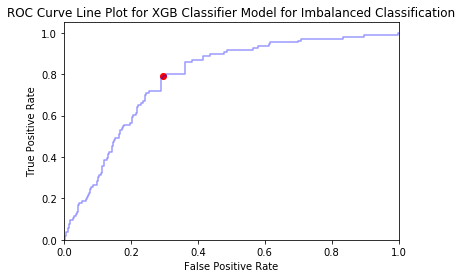

Best Threshold=0.022934, G-Mean=0.747


In [254]:
# plot the roc curve for the model

plt.step(fpr, tpr, color='b', alpha=0.4, where='post')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC Curve Line Plot for XGB Classifier Model for Imbalanced Classification')
plt.show()

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

### Confusion Matrix

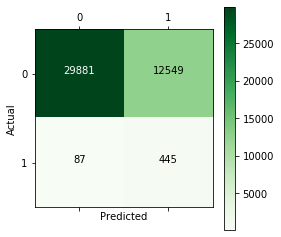

In [273]:
# Analyze of confuse matrix with optimal threshold value for train dataset


train_pred = final_model.predict_proba(mailout_train)[:,1]
thresh = 0.022934
train_pred [train_pred > thresh] = 1
train_pred [train_pred <= thresh] = 0
cm = confusion_matrix(labels, train_pred)
#plot_confusion_matrix(cm, ['0', '1'], )
#pr, tpr, fpr = show_data(cm, print_res = 1);


plt.matshow(cm,cmap=plt.cm.Greens)  # plot matrix    
plt.colorbar() 
plt.xlabel('Predicted')
plt.ylabel('Actual')

# plotting text value inside cells
thresh = cm.max() / 2.
for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],'d'),horizontalalignment='center',color='white' if cm[i,j] >thresh else 'black')
plt.show();


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [137]:
mailout_test = pd.read_csv('./Data/mailout_test.csv')

C:\Users\Mustafa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [138]:
mailout_test_LNR = mailout_test["LNR"]
mailout_test = clean_data_for_supervised(mailout_test, attribute)
mailout_test = pd.DataFrame(scaler.transform(mailout_test), columns = mailout_test.columns)

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding OST_WEST_KZ column
	Dropping extra columns
	Imputing missing values with most frequent ones
Completed Cleaning in 23.036460161209106 seconds


### Fitting the best models on complete train data and Making predictions on test data

### <ins>Final XGB Classifier Model</ins>

In [139]:
final_model.fit(mailout_train, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=None, n_estimators=76, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)

In [140]:
preds_test_xgb = final_model.predict_proba(mailout_test)[:,1]

In [141]:
kaggle_final_model = pd.DataFrame(index=mailout_test_LNR, data=preds_test_xgb)
kaggle_final_model.rename(columns={0: "RESPONSE"}, inplace=True)

In [142]:
kaggle_final_model.head()

,RESPONSE
LNR,
1754,0.050914
1770,0.036217
1465,0.014228
1470,0.015745
1478,0.016987


In [143]:
kaggle_final_model.to_csv("./Submissions/Submission.csv")